In [2]:
using Flux
using Zygote: Buffer

using M4

┌ Info: Precompiling M4 [2195a5f3-7642-4e25-ac27-a7b8005e7ce1]
└ @ Base loading.jl:1273
┌ Warning: /home/gleb/.julia/packages/Plots/12uaJ/src/Plots.jl/ is not an existing directory, Revise is not watching
└ @ Revise /home/gleb/.julia/packages/Revise/SZ4ae/src/Revise.jl:489


In [3]:
train_dict = read_series("../data/M4/Train/Monthly-train.csv")
test_dict = read_series("../data/M4/Test/Monthly-test.csv")
info_dict = read_info("../data/M4/M4-info.csv")

Dict{String,SeriesInfo} with 100000 entries:
  "M45761" => SeriesInfo("M45761", "Finance", 0x000c, "Monthly", 0x0012, 0010-0…
  "M26424" => SeriesInfo("M26424", "Demographic", 0x000c, "Monthly", 0x0012, 00…
  "Y8539"  => SeriesInfo("Y8539", "Micro", 0x0001, "Yearly", 0x0006, 0077-12-31…
  "Y7057"  => SeriesInfo("Y7057", "Micro", 0x0001, "Yearly", 0x0006, 0069-01-01…
  "D2238"  => SeriesInfo("D2238", "Finance", 0x0001, "Daily", 0x000e, 0001-03-3…
  "Q7214"  => SeriesInfo("Q7214", "Micro", 0x0004, "Quarterly", 0x0008, 0091-01…
  "Y3211"  => SeriesInfo("Y3211", "Macro", 0x0001, "Yearly", 0x0006, 0085-12-31…
  "Y5114"  => SeriesInfo("Y5114", "Micro", 0x0001, "Yearly", 0x0006, 0069-01-01…
  "M16981" => SeriesInfo("M16981", "Micro", 0x000c, "Monthly", 0x0012, 0008-08-…
  "M44763" => SeriesInfo("M44763", "Finance", 0x000c, "Monthly", 0x0012, 0007-0…
  "M43839" => SeriesInfo("M43839", "Finance", 0x000c, "Monthly", 0x0012, 0087-1…
  "M21140" => SeriesInfo("M21140", "Demographic", 0x000c, "Month

SeriesInfo("M3", "Macro", 0x000c, "Monthly", 0x0012, 0076-06-01T12:00:00)

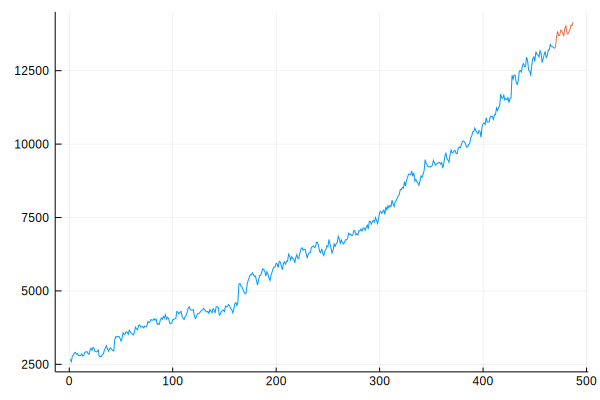

In [4]:
series_id = "M3"
train_series = train_dict[series_id]
test_series = test_dict[series_id]
info = info_dict[series_id]

print(info)
plot_pieces(train_series, test_series)

In [37]:
import M4: roll_window

input_size = info.freq * 5
output_size = info.horizon
println(input_size, " ", output_size)

inputs, outputs = roll_window(train_series, input_size, output_size)
println(size(inputs), " ", size(outputs))

60 18
(60, 392) (18, 392)


In [29]:
dense = Dense(input_size, output_size)
dense(inputs)

Tracked 18×392 Array{Float32,2}:
  2644.19     2633.45    2686.43   …   10421.1     10666.3     10555.3  
 -5352.12    -5373.28   -5315.86      -19723.6    -20076.1    -20295.9  
  -673.881    -856.487   -737.268      -3600.22    -3939.22    -3708.36 
 -3246.9     -3127.28   -3232.09      -11579.4    -11648.6    -11609.5  
  3408.9      3579.06    3697.82       14560.8     14445.1     14431.1  
 -4126.14    -3955.29   -3853.29   …  -15580.0    -15970.8    -15966.7  
 -7028.33    -7110.23   -7033.84      -26204.3    -26483.3    -26856.2  
  6009.01     6089.23    6101.88       23069.6     22873.1     22791.6  
   538.63      521.455    529.905       1473.44     1298.78     1162.15 
 -2012.56    -2060.48   -2173.67       -7491.92    -7380.74    -7522.29 
 -2760.36    -2831.82   -2660.46   …  -10149.9    -10371.2    -10554.5  
 -3939.44    -3984.54   -4065.53      -15379.7    -15134.3    -15055.9  
  6709.11     6660.84    6705.4        25067.1     25079.0     25494.9  
 -5722.17    -5765

In [47]:
struct HoltWinters
    input_size::Int64
    output_size::Int64
    freq::Int64
    
    level_smooth::Vector{Float64}
    trend_smooth::Vector{Float64}
    season_smooth::Vector{Float64}
    
    level_init::Vector{Float64}
    trend_init::Vector{Float64}
    season_init::Vector{Float64}
end


function HoltWinters(input_size, output_size, freq)
    level_smooth = [0.5]
    trend_smooth = [0.5]
    season_smooth = [0.5]
    
    level_init = [0.5]
    trend_init = [0.5]
    season_init = repeat([0.5], freq)

    HoltWinters(
        input_size, output_size, freq, 
        level_smooth, trend_smooth, season_smooth, 
        level_init, trend_init, season_init)    
end
    

function (model::HoltWinters)(input::Vector{Float64})
    level_smooth = model.level_smooth[1]
    trend_smooth = model.level_smooth[1]
    season_smooth = model.season_smooth[1]

    level = Buffer([], Float64, model.input_size)
    trend = Buffer([], Float64, model.input_size)
    season = Buffer([], Float64, model.input_size)

    for t in 1:model.input_size
        level_prev = t == 1 ? model.level_init[1] : level[t - 1]
        trend_prev = t == 1 ? model.trend_init[1] : trend[t - 1]
        season_prev = t <= model.freq ? model.season_init[t] : season[t - model.freq]
        
        level[t] = (level_smooth * (input[t] - season_prev) 
            + (1 - level_smooth) * (level_prev + trend_prev))
        
        trend[t] = (trend_smooth * (level[t] - level_prev) 
            + (1 - trend_smooth) * trend_prev)
        
        season[t] = (season_smooth * (input[t] - level_prev - trend_prev) 
            + (1 - season_smooth) * season_prev)
    end
    
    pred = Buffer([], Float64, model.output_size)
    
    for h in 1:model.output_size
        k = floor(Int64, (h - 1) / model.freq)
        
        pred[h] = (level[model.input_size] 
            + h * trend[model.input_size] 
            + season[model.input_size + h - model.freq * (k + 1)])
    end
    
    copy(pred)
end

model = HoltWinters(input_size, output_size, info.freq)
model(windows[2][1])


18-element Array{Float64,1}:
 3825.1161402188973
 4056.5153031309615
 4249.999459115128 
 4007.8460039044635
 3584.69721022821  
 3011.047025300921 
 2414.4288300487924
 1854.8071230868334
 1558.6682638893567
 1327.68283493307  
 1336.752586202345 
 1435.9473875232297
 1734.0635277421272
 1965.4626906541912
 2158.9468466383587
 1916.7933914276932
 1493.6445977514404
  919.9944128241514